### 作業
請嘗試使用 keras 來定義一個直接預測 15 個人臉關鍵點坐標的檢測網路，以及適合這個網路的 loss function


Hint: 參考前面的電腦視覺深度學習基礎

### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## 使用 colab 環境的同學請執行以下程式碼
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [3]:
 import os
 from google.colab import drive 
 drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/My Drive/python_training/DL100_CV/day_43/'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

/content/gdrive/My Drive/python_training/DL100_CV/day_43


In [5]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [6]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)

In [7]:
print(points_train[0:3,:])

[[ 0.18784958 -0.09372631 -0.18513533 -0.12060753  0.12064666 -0.087006
   0.26177448 -0.08364585 -0.12128571 -0.11052707 -0.25569928 -0.11052707
   0.09326315 -0.19756618  0.33569926 -0.16429022 -0.08096242 -0.19789249
  -0.32962108 -0.19117218 -0.03728572  0.09444588  0.13745111  0.3330226
  -0.20193234  0.30613536 -0.04882705  0.25974435 -0.05072179  0.38006014]
 [ 0.17013478 -0.13572836 -0.18802837 -0.1515759   0.11308509 -0.13255885
   0.23669505 -0.12305036 -0.12463829 -0.1420674  -0.245078   -0.15474537
   0.06236881 -0.20545885  0.3191064  -0.18327162 -0.0549078  -0.2276454
  -0.32431912 -0.21813688  0.00214893  0.07980138  0.08772343  0.29533333
  -0.13414183  0.29216313 -0.01370212  0.23194331 -0.02637589  0.39041847]
 [ 0.17767763 -0.1363579  -0.17808554 -0.1363579   0.11887497 -0.12165657
   0.23942107 -0.12165657 -0.10751975 -0.12165657 -0.23982894 -0.11871645
   0.08065134 -0.21280262  0.32174343 -0.15987894 -0.06048027 -0.20692238
  -0.32509208 -0.1657592  -0.00461185  0

In [8]:
#shuffle
index=np.arange(len(points_train))

print(index)

[   0    1    2 ... 2137 2138 2139]


In [9]:
np.random.seed(2018)
np.random.shuffle(index)
print(index)

[2000  552  145 ... 1689  917 1274]


In [10]:
points_train=points_train[index]
print(points_train[0:3,:])

[[ 0.2274993  -0.15356454 -0.22842321 -0.144667    0.14159197 -0.11674711
   0.3136828  -0.13597193 -0.14282265 -0.11091769 -0.3164782  -0.12840596
   0.12080616 -0.24481091  0.377949   -0.2318007  -0.11024234 -0.21206859
  -0.3785127  -0.20414001  0.00733572  0.16424358  0.19374323  0.3292839
  -0.17054138  0.3336045   0.00606507  0.3541276   0.00525498  0.3781612 ]
 [ 0.18523568 -0.12443313 -0.18766242 -0.12158599  0.10837579 -0.11110827
   0.25924844 -0.11304459 -0.11694905 -0.11307004 -0.2616688  -0.11019745
   0.1112293  -0.22975159  0.32187265 -0.19559237 -0.11080253 -0.22690445
  -0.33568153 -0.18136308  0.02582806  0.05490446  0.16815925  0.25985354
  -0.15350318  0.2683949   0.01729298  0.18299365  0.01444584  0.34240127]
 [ 0.24262905 -0.16172823 -0.20787904 -0.17974839  0.15328223 -0.16254273
   0.30750805 -0.15451935 -0.12137902 -0.17254034 -0.27635485 -0.16533229
   0.14171773 -0.2806629   0.38679838 -0.22299758 -0.12137902 -0.309496
  -0.36645967 -0.26264274  0.01651615  

In [11]:
imgs_train=imgs_train[index]
print(imgs_train[0:3,:])

[[[0.85490197 0.84313726 0.8509804  ... 0.3372549  0.18431373 0.14509805]
  [0.85882354 0.8509804  0.85882354 ... 0.3529412  0.20784314 0.14901961]
  [0.83137256 0.84313726 0.85490197 ... 0.36862746 0.22745098 0.16078432]
  ...
  [0.5764706  0.5254902  0.5372549  ... 0.16862746 0.14509805 0.12156863]
  [0.56078434 0.5137255  0.5176471  ... 0.16862746 0.14117648 0.11372549]
  [0.5686275  0.5176471  0.5019608  ... 0.15686275 0.13333334 0.10980392]]

 [[0.4862745  0.49019608 0.5058824  ... 0.7294118  0.72156864 0.7176471 ]
  [0.48235294 0.49019608 0.5058824  ... 0.7254902  0.7294118  0.7294118 ]
  [0.49803922 0.49019608 0.5058824  ... 0.7254902  0.72156864 0.7254902 ]
  ...
  [0.07843138 0.07450981 0.05098039 ... 0.5803922  0.6039216  0.5254902 ]
  [0.06666667 0.05882353 0.05098039 ... 0.45490196 0.6        0.6117647 ]
  [0.05490196 0.05490196 0.05490196 ... 0.37254903 0.53333336 0.64705884]]

 [[0.37254903 0.42352942 0.47058824 ... 0.8117647  0.7764706  0.78039217]
  [0.39215687 0.423529

In [12]:
# after shuffle, 讀取資料
print("after shuffle, 圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

after shuffle, 圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [13]:
#split train/val
split_len = int(len(points_train)*0.8)
train_point = points_train[0:split_len,:]
train_img = imgs_train[0:split_len,:]
val_point = points_train[split_len:,:]
val_img = imgs_train[split_len:,:]

print('train_point:',train_point.shape)
print('train_img:',train_img.shape)
print('val_point:',val_point.shape)
print('val_img:',val_img.shape)

train_point: (1712, 30)
train_img: (1712, 96, 96)
val_point: (428, 30)
val_img: (428, 96, 96)


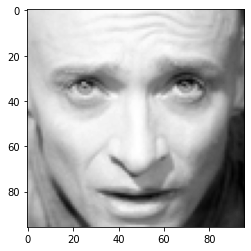

In [14]:
plt.imshow(train_img[0],cmap=plt.cm.gray)

In [15]:
#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import utils
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras import layers

Using TensorFlow backend.


In [16]:
def FKPD_model(size):
    input_data = Input(size)
    
    x = Conv2D(32, (3, 3), activation='relu')(input_data)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (2, 2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (2, 2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024,activation='relu')(x)
    output = Dense(30)(x)
    return Model(inputs=input_data, outputs=output, name='FKPD_model')

In [17]:
model=FKPD_model((96, 96, 1))
print(model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [18]:
model.summary()

Model: "FKPD_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0

In [19]:
#生成器generator
def generate_for_kp(file_list, label_list, batch_size):
    while True:
        count = 0
        x, y = [], []
        for i,path in enumerate(file_list):
            #img=io.imread(path)
            #img = np.array(img)
            #x_temp=img/255.0
            x_temp = path
            y_temp=(label_list[i,:]-48.0)/48.0
            count += 1
            x.append(x_temp)
            y.append(y_temp)
            if count % batch_size == 0 and count != 0:
                x = np.array(x)
                x = x.reshape(batch_size, 96, 96, 1).astype("float32")
                y = np.array(y)
                yield x, y
                x, y = [], []
                
def generate_for_kp_test(file_list, batch_size):
    while True:
        count = 0
        x= []
        for path in file_list:
            #img=io.imread(path)
            #img = np.array(img)
            #x_temp=img/255.0
            x_temp = path
            count += 1
            x.append(x_temp)
            if count % batch_size == 0 and count != 0:
                x = np.array(x)
                x = x.reshape(batch_size, 96, 96, 1).astype("float32")
                yield x
                x = []

In [20]:
epoch_num = 10
batch = 32
step_per_epoch  = int(len(train_point)/batch)+1
learning_rate = np.linspace(0.03, 0.01, epoch_num)
change_lr = LearningRateScheduler(lambda epoch: float(learning_rate[epoch]))

In [21]:

# 如果超過3次的循環在loss的收歛上沒有改善就停止訓練 
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='auto',  #min
                           verbose=1)

# 每次的訓練循都去比較模型的loss是否有改善, 有就把模型的權重儲存下來
checkpoint = ModelCheckpoint('FKPD_model.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', #min
                             period=1)


In [ ]:
# 配置 loss funtion 和 optimizer
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9, nesterov=True)
#optimizer = SGD(lr=0.03, momentum=0.9, nesterov=True)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='mse', optimizer=optimizer)

history = model.fit_generator( generate_for_kp(train_img,train_point,batch),
                    steps_per_epoch  = step_per_epoch,
                    epochs = epoch_num,
                    verbose = 1,
                    validation_data  = generate_for_kp(val_img,val_point,batch),
                    validation_steps = step_per_epoch,
                    callbacks = [change_lr, early_stop,checkpoint]) ##change_lr


In [23]:
model.load_weights('FKPD_model.h5')

In [24]:
#draw train results
print('training results:')
predict_point= []
for i,t in enumerate(train_img):
    #print(i,t)
    prediction=model.predict(t.reshape(1, 96, 96, 1))[0]  ##1, 
    #print(t.shape)
    #prediction=prediction*48.0+48.0
    prediction=(prediction+0.5)*96
    predict_point.append(prediction)
    predict_data = np.array(predict_point)

training results:



In [ ]:

x_list=predict_data[4][np.arange(0,29,2)]
y_list=predict_data[4][np.arange(1,30,2)]
x_list_real=train_point[4][np.arange(0,29,2)]
y_list_real=train_point[4][np.arange(1,30,2)]

plt.imshow(train_img[4],cmap=plt.cm.gray)
plt.scatter(x_list,y_list,c='r')
plt.scatter(x_list_real,y_list_real,c='b')

plt.show()

In [25]:
sample_img = train_img[4]
sample_points = train_point[4]
predict_points = predict_data[4]

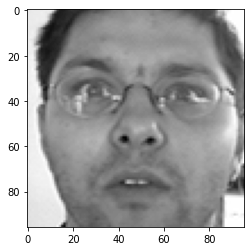

In [26]:
plt.imshow(sample_img, cmap='gray')

In [46]:
def plot_keypoints(img, points, pre_points):
    # your code here
    # 顯示圖片
    plt.imshow(img, cmap='gray')
    # 把關鍵點畫上去
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='b')
        #plt.scatter((pre_points[i] + 0.5)*96, (pre_points[i+1]+0.5)*96, color='red')
        plt.scatter((pre_points[i]+48)*48, (pre_points[i+1]+48)*48, color='red')

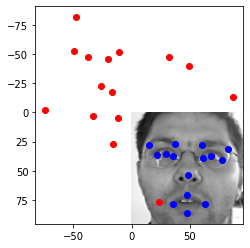

In [47]:
plot_keypoints(sample_img, sample_points, predict_points)